`Energy Demand Forecasting Project`

In [1]:
# import required packages for Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from math import sqrt

# get rid of annoying future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter

# import other functions we'll need for regression modeling
from sklearn.ensemble import RandomForestRegressor # RFR
from sklearn.ensemble import GradientBoostingRegressor #GBR

# regression error metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [ ]:
# Read CSV file
df = pd.read_csv('BDL_cleanweather_energy (1).csv')

In [ ]:
df.info() #checking the datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96427 entries, 0 to 96426
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96427 non-null  object 
 1   Demand    96427 non-null  float64
 2   BDL_tmpf  96160 non-null  float64
 3   BDL_dwpf  96160 non-null  float64
 4   BDL_relh  96160 non-null  float64
 5   BDL_drct  96160 non-null  float64
 6   BDL_sknt  96160 non-null  float64
 7   BDL_p01i  96160 non-null  float64
 8   BDL_alti  96160 non-null  float64
 9   BDL_mslp  96160 non-null  float64
 10  BDL_vsby  96160 non-null  float64
dtypes: float64(10), object(1)
memory usage: 8.1+ MB


Sorted the data from oldest to newest before performing any analysis or feature engineering for easy interpretation

In [ ]:
#Sorting the data
df = df.sort_values(by='Datetime', ascending = True)

## Data Dictionary
Scroll down to see the data dictionary.
* https://mesonet.agron.iastate.edu/request/download.phtml

The Demand column is energy usage across all of New England. The weather data is for Bradley Airport in Connecticut (BDL).

#Exploratory Data Analysis


In [ ]:
# Check for missing values in all columns
df.isna().sum()

Datetime      0
Demand        0
BDL_tmpf    267
BDL_dwpf    267
BDL_relh    267
BDL_drct    267
BDL_sknt    267
BDL_p01i    267
BDL_alti    267
BDL_mslp    267
BDL_vsby    267
dtype: int64

In [ ]:
# Impute the missing values 
# We are using forward imputation considering the execution runtime and model results 
df1 = df 
df1.fillna(method ='pad',inplace=True)


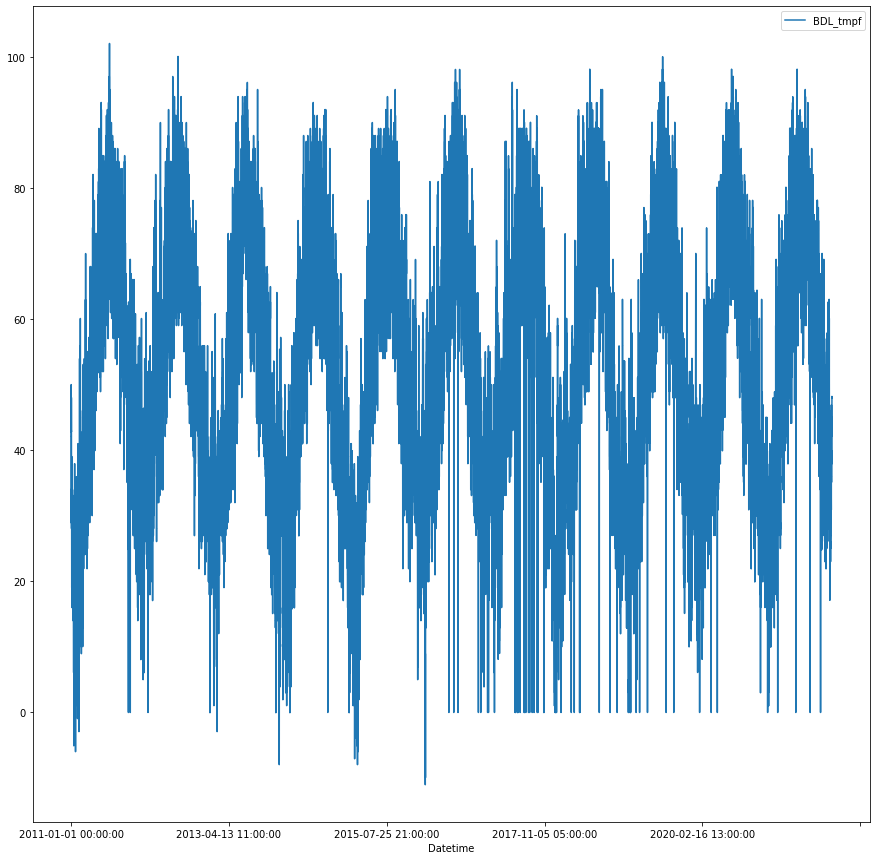

<Figure size 432x288 with 0 Axes>

In [ ]:
# checking the temperature distribution across time after imputation 
df1.plot.line(x='Datetime', y='BDL_tmpf')
plt.figure(figsize=(6,4))
plt.show()

In [ ]:
#Checking missing values after treatment
df1.isna().sum()

Datetime    0
Demand      0
BDL_tmpf    0
BDL_dwpf    0
BDL_relh    0
BDL_drct    0
BDL_sknt    0
BDL_p01i    0
BDL_alti    0
BDL_mslp    0
BDL_vsby    0
dtype: int64

In [ ]:
df1.info() #checking datatypes after imputation

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96427 entries, 8760 to 78859
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96427 non-null  object 
 1   Demand    96427 non-null  float64
 2   BDL_tmpf  96427 non-null  float64
 3   BDL_dwpf  96427 non-null  float64
 4   BDL_relh  96427 non-null  float64
 5   BDL_drct  96427 non-null  float64
 6   BDL_sknt  96427 non-null  float64
 7   BDL_p01i  96427 non-null  float64
 8   BDL_alti  96427 non-null  float64
 9   BDL_mslp  96427 non-null  float64
 10  BDL_vsby  96427 non-null  float64
dtypes: float64(10), object(1)
memory usage: 8.8+ MB


In [ ]:
df1.head() #to see top 5 rows of the data

,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
8760,2011-01-01 00:00:00,3053.0,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0
8761,2011-01-01 01:00:00,2892.0,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0
8762,2011-01-01 02:00:00,2774.0,30.92,26.96,0.0,0.0,0.0,0.0,30.07,1018.6,6.0
8763,2011-01-01 03:00:00,2710.0,30.02,26.06,0.0,0.0,0.0,0.0,30.09,1019.2,5.0
8764,2011-01-01 04:00:00,2698.0,28.94,24.98,0.0,0.0,0.0,0.0,30.09,1019.1,5.0


In [ ]:
df1.describe() 

,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
count,96427.000000,96427.000000,96427.000000,96427.000000,96427.000000,96427.000000,96427.00000,96427.000000,96427.000000,96427.000000
mean,3388.580129,51.950908,39.653514,65.614181,221.284391,7.562021,0.00553,30.017906,1009.986335,9.338270
std,761.491626,19.309548,19.689528,21.411280,118.619243,4.769616,0.03710,0.290478,80.922661,1.981883
min,1372.000000,-11.020000,-27.040000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,2843.000000,36.000000,24.980000,49.500000,170.000000,4.000000,0.00000,29.870000,1011.100000,10.000000
50%,3333.420000,52.000000,41.000000,66.650000,230.000000,7.000000,0.00000,30.020000,1016.300000,10.000000
75%,3813.000000,68.000000,55.940000,84.460000,330.000000,10.000000,0.00000,30.170000,1021.500000,10.000000
max,7219.000000,102.020000,78.080000,100.000000,360.000000,40.000000,1.96000,30.850000,1044.700000,10.000000


In [ ]:
# we need to convert datetime column to datetime format

df1['Datetime'] = pd.to_datetime(df1['Datetime'])

In [ ]:
df1.dtypes # Validate the datatypes

Datetime    datetime64[ns]
Demand             float64
BDL_tmpf           float64
BDL_dwpf           float64
BDL_relh           float64
BDL_drct           float64
BDL_sknt           float64
BDL_p01i           float64
BDL_alti           float64
BDL_mslp           float64
BDL_vsby           float64
dtype: object

#Graphs

##1. Plotting Distribution plots for all the columns

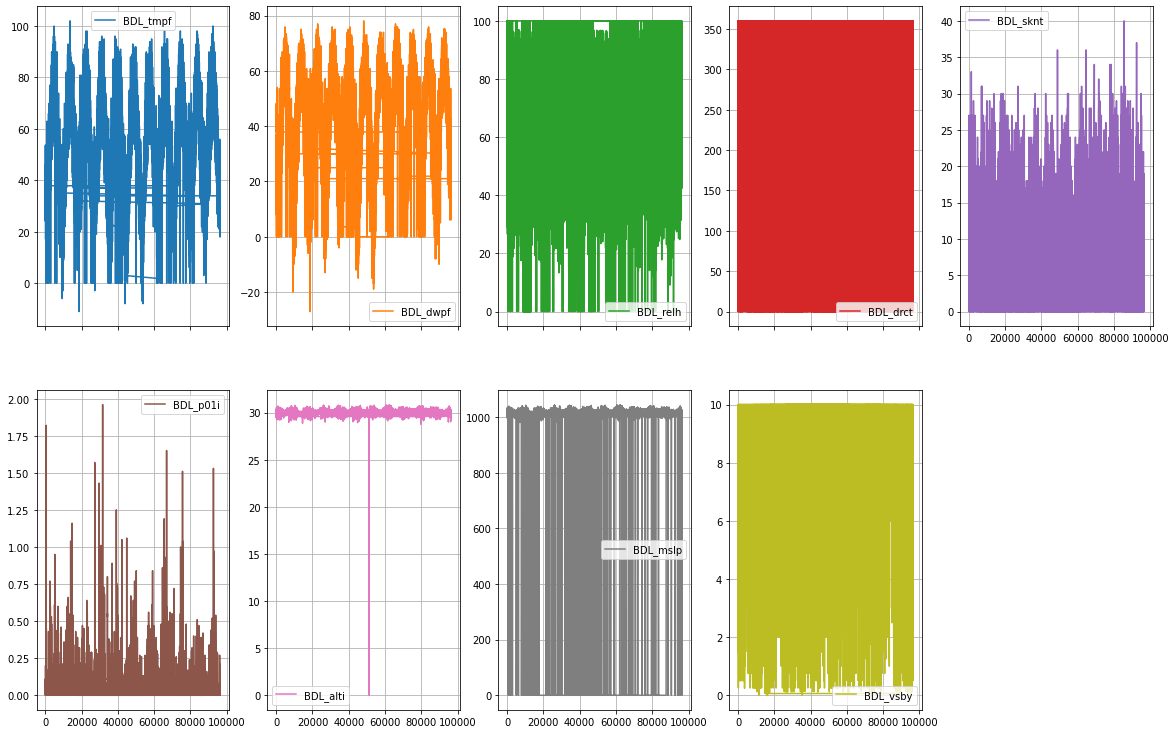

In [ ]:
# Check distribution of all the dependent variables
tmp1 = df1.loc[:, 'BDL_tmpf':'BDL_vsby']
tmp1.head()

import seaborn as sns
tmp1.plot(subplots=True,
        grid=True, 
        layout=(3,5),
         figsize=(20,20))
plt.show()

The aforementioned graphs demonstrate that each variable is performing differently and, as a result, will have a different impact on demand.

##2. Bar Plot for Yearly data

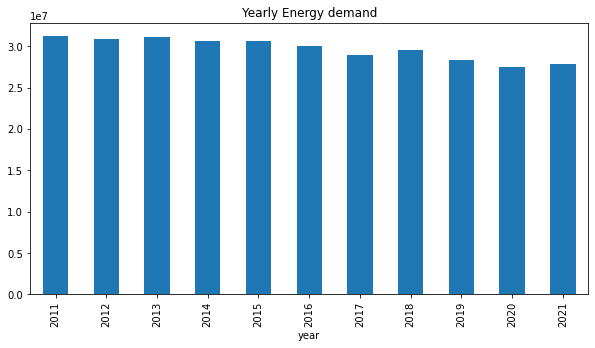

In [ ]:
# Creating a new column Year to plot yearly graph
df1['year'] = df1['Datetime'].dt.year

x_year = df1.groupby(['year']).sum()
plt.figure(figsize=(10,5))
x_year['Demand'].plot.bar(title='Yearly Energy demand')
plt.show() 

From the above graph, we can infer that 2011 and 2013 were the years with the highest energy demand since they have the highest peak among all the years.
Also we can see, demand keeps on fluctuating over the following years after 2013.

##3. Scatter plot for Demand vs Temperature

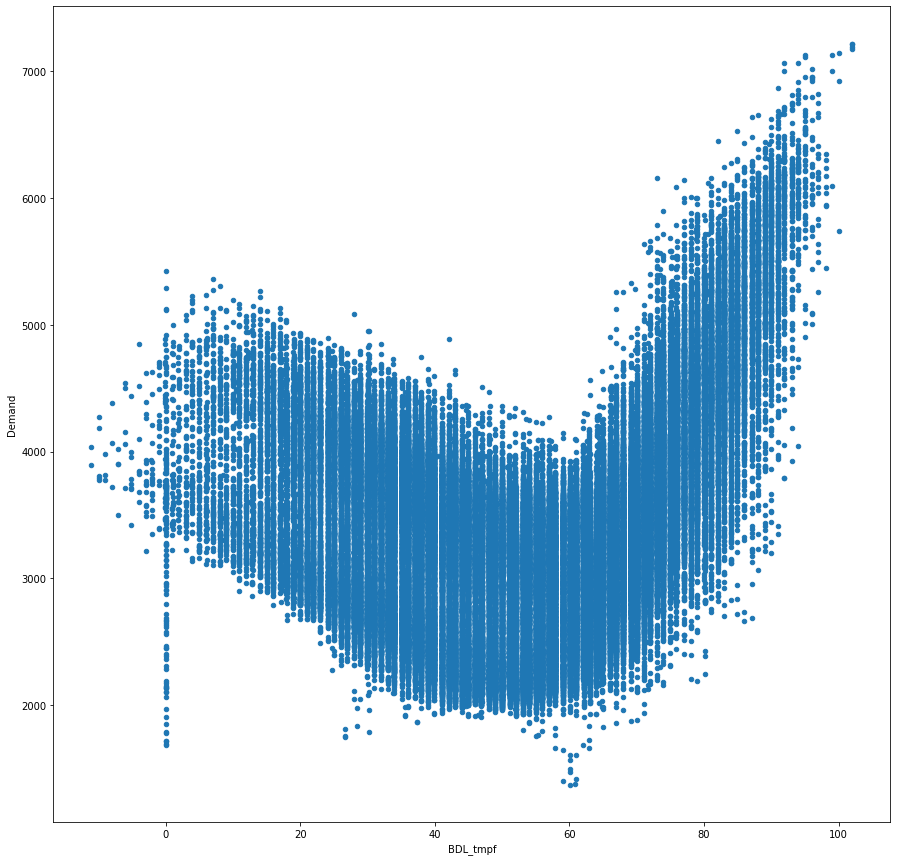

<Figure size 432x288 with 0 Axes>

In [ ]:
# here is a scatterplot using the temperature and demand
df.plot.scatter(x='BDL_tmpf', y='Demand')
plt.figure(figsize=(6,4))
plt.show()

The above graph displays that as the temperature rises, the demand rises.As we can see, when temperature is highest the demand is highest.

Also we can observe that when Temperature is low, the energy demand is high which can be due to usage of heaters in winters.

##4. Bar Plot for weekly data

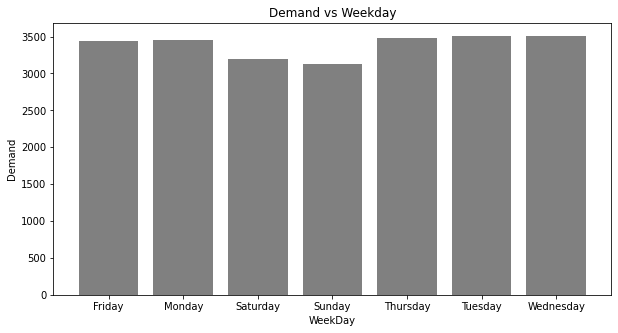

In [ ]:
df2 = df #copy data to df2 from df
# imputing forward fill
df2 = df2.fillna(df2.mean()['BDL_tmpf':'BDL_vsby'])
df2['Datetime'] = pd.to_datetime(df2['Datetime'])

#Creating a new column weekday to plot weekly graph
df2['week_day']=df2['Datetime'].apply(lambda x:x.dayofweek)
conditions=[(df2['week_day']==0),(df2['week_day']==1),(df2['week_day']==2),(df2['week_day']==3),(df2['week_day']==4),(df2['week_day']==5),(df2['week_day']==6)]
choices=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df2['weekday_name']=np.select(conditions,choices,default='NA')
#df2.head()

#plotting the bar graph for weekly distribution of demand

df_check_week=df2.groupby(['weekday_name'],as_index=False).mean()
x=df_check_week['weekday_name']
dem=df_check_week['Demand']
x_pos = [i for i, _ in enumerate(x)]
plt.figure(figsize=(10,5))
plt.bar(x_pos, dem, color='gray')
plt.xlabel("WeekDay")
plt.ylabel("Demand")
plt.title("Demand vs Weekday")

plt.xticks(x_pos, x)
plt.show()

We can infer from the above graph  that demand is lowest on weekends compared to weekdays. Additionally, demand on weekdays is consistent throughout the days, while demand on weekends is significantly lower than on weekdays.

## 5. Bar plot of demand on an hourly basis

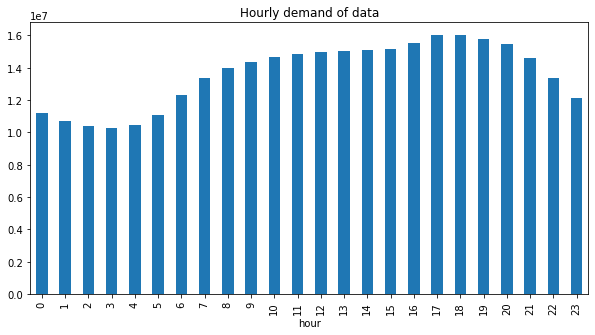

In [ ]:
import seaborn as sns
#Creating a new column hour to plot hourly graph
df1['hour'] = df1['Datetime'].dt.hour

x_year = df1.groupby(['hour']).sum()
plt.figure(figsize=(10,5))
x_year['Demand'].plot.bar(title='Hourly demand of data')
plt.show()


The graph above indicates that demand is higher during the day than at night. 
The top hour for demand is 5 pm, after that the demand start gradually declining.
The demand start rising from 7 am in the morning and will decline after 6 pm.

## 6. Bar plot of demand on the basis of Humidity

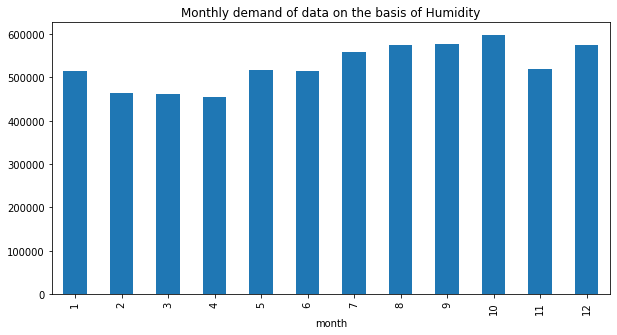

In [ ]:
import seaborn as sns

#Creating a new column month to plot monthly humidity graph
df1['month'] = df1['Datetime'].dt.month

x_year = df1.groupby(['month']).sum()
plt.figure(figsize=(10,5))
x_year['BDL_relh'].plot.bar(title='Monthly demand of data on the basis of Humidity')
plt.show()


The graph above indicates that demand is higher during July to October on comparing it on the bais of Humidity which shows that when their is higher humidity, the demand will be higher.

7. Boxplots for all variables to explore outliers

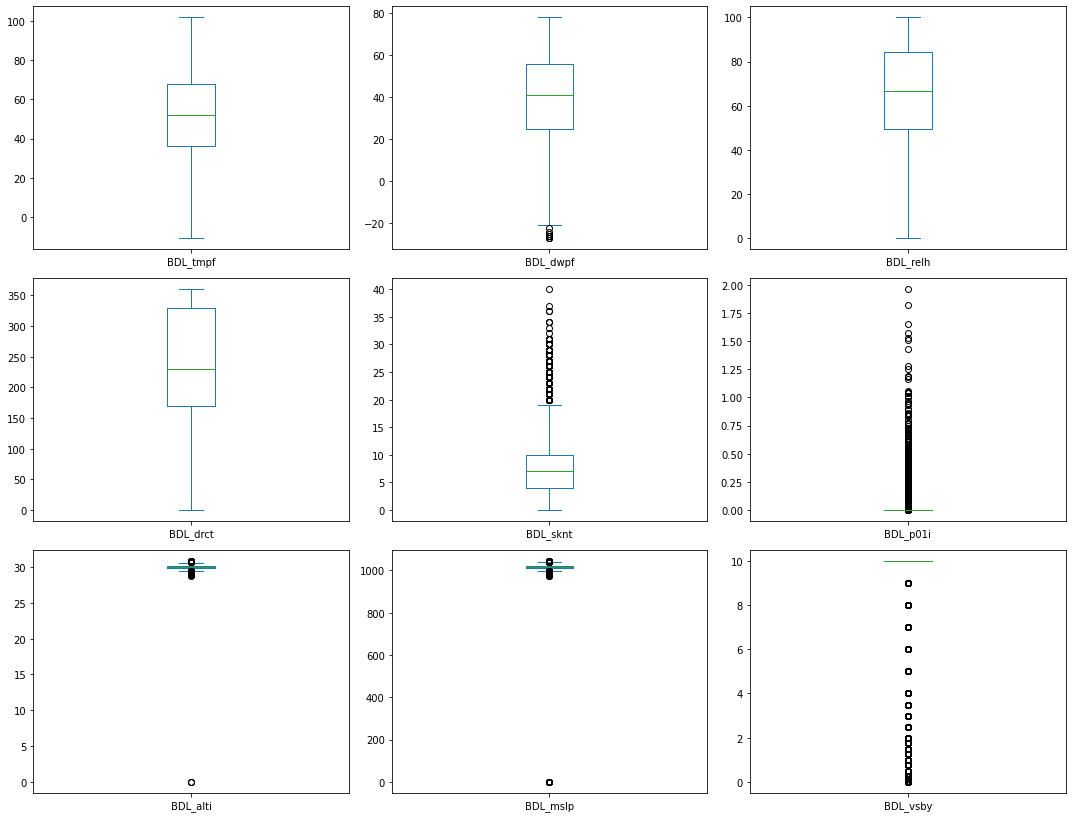

In [ ]:
tmp1.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.rcParams["figure.figsize"] = (15,15)
plt.tight_layout() 
plt.show()

# Explore Outliers

We explored the boundary limits for all the columns to handle the outliers.
Further implemented outliers formula to get the values.

In [ ]:
print("Highest allowed",df1['BDL_mslp'].mean() + 3*df1['BDL_mslp'].std())
print("Lowest allowed",df1['BDL_mslp'].mean() - 3*df1['BDL_mslp'].std())

Highest allowed 1252.7543182161423
Lowest allowed 767.2183512643974


In [ ]:
print("Highest allowed",df1['BDL_alti'].mean() + 3*df1['BDL_alti'].std())
print("Lowest allowed",df1['BDL_alti'].mean() - 3*df1['BDL_alti'].std())

Highest allowed 30.889339401859452
Lowest allowed 29.146473596574587


In [ ]:
print("Highest allowed",df1['BDL_tmpf'].mean() + 3*df1['BDL_tmpf'].std())
print("Lowest allowed",df1['BDL_tmpf'].mean() - 3*df1['BDL_tmpf'].std())

Highest allowed 109.879551128414
Lowest allowed -5.977735661791577


In [ ]:
print("Highest allowed",df1['BDL_dwpf'].mean() + 3*df1['BDL_dwpf'].std())
print("Lowest allowed",df1['BDL_dwpf'].mean() - 3*df1['BDL_dwpf'].std())

Highest allowed 98.72209733028055
Lowest allowed -19.415068800926726


In [ ]:
print("Highest allowed",df1['BDL_relh'].mean() + 3*df1['BDL_relh'].std())
print("Lowest allowed",df1['BDL_relh'].mean() - 3*df1['BDL_relh'].std())

Highest allowed 129.84801970676804
Lowest allowed 1.380342059127429


In [ ]:
print("Highest allowed",df1['BDL_drct'].mean() + 3*df1['BDL_drct'].std())
print("Lowest allowed",df1['BDL_drct'].mean() - 3*df1['BDL_drct'].std())

Highest allowed 577.1421206708286
Lowest allowed -134.57333806844545


In [ ]:
print("Highest allowed",df1['BDL_sknt'].mean() + 3*df1['BDL_sknt'].std())
print("Lowest allowed",df1['BDL_sknt'].mean() - 3*df1['BDL_sknt'].std())

Highest allowed 21.87086877222804
Lowest allowed -6.746826750802505


In [ ]:
print("Highest allowed",df1['BDL_p01i'].mean() + 3*df1['BDL_p01i'].std())
print("Lowest allowed",df1['BDL_p01i'].mean() - 3*df1['BDL_p01i'].std())

Highest allowed 0.11682873800682034
Lowest allowed -0.1057686428052689


In [ ]:
print("Highest allowed",df1['BDL_vsby'].mean() + 3*df1['BDL_vsby'].std())
print("Lowest allowed",df1['BDL_vsby'].mean() - 3*df1['BDL_vsby'].std())

Highest allowed 15.283919195595256
Lowest allowed 3.392620985059536


# Remove Outliers

In [ ]:
# subsetting the dataset based on the results above to remove outliers
df1 = df1.loc[(df1['BDL_alti'] > 29) & (df1['BDL_mslp'] > 770) & (df1['BDL_relh'] > 1.45) 
& (df1['BDL_sknt'] < 21.87) & (df1['BDL_p01i'] < 0.12) & (df1['BDL_vsby'] > 3.4)]

In [ ]:
df1.describe() #Checking result after removing outliers

,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby,year,hour,month
count,89025.000000,89025.00000,89025.000000,89025.000000,89025.000000,89025.000000,89025.000000,89025.000000,89025.000000,89025.000000,89025.000000,89025.000000,89025.000000
mean,3389.573199,52.61016,39.741922,64.745127,223.059365,7.468913,0.001709,30.027868,1016.715184,9.741376,2016.072530,11.557046,6.584634
std,766.575825,19.31498,19.769061,19.991404,116.294037,4.452643,0.009539,0.233389,7.952534,0.996923,3.132815,6.941143,3.401290
min,1372.000000,-11.02000,-27.040000,9.110000,0.000000,0.000000,0.000000,29.020000,981.200000,3.500000,2011.000000,0.000000,1.000000
25%,2844.002000,37.04000,24.100000,49.190000,170.000000,4.000000,0.000000,29.880000,1011.600000,10.000000,2013.000000,6.000000,4.000000
50%,3330.000000,53.10000,41.000000,65.350000,230.000000,7.000000,0.000000,30.020000,1016.600000,10.000000,2016.000000,12.000000,7.000000
75%,3809.636000,68.00000,57.000000,82.040000,320.000000,10.000000,0.000000,30.180000,1021.800000,10.000000,2019.000000,18.000000,10.000000
max,7219.000000,102.02000,78.080000,100.000000,360.000000,21.000000,0.110000,30.850000,1044.700000,10.000000,2021.000000,23.000000,12.000000


In [ ]:
tmp2 = df1.loc[:, 'BDL_tmpf':'BDL_vsby']
tmp2.head()

,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
8768,33.98,28.04,78.62,20.0,3.0,0.0,30.12,1019.9,4.0
8773,50.00,35.06,56.30,170.0,5.0,0.0,30.04,1017.1,7.0
8774,50.00,33.98,53.92,160.0,3.0,0.0,30.02,1016.6,7.0
8775,48.92,35.06,58.61,180.0,6.0,0.0,30.02,1016.6,10.0
8776,46.94,35.06,63.13,190.0,5.0,0.0,30.01,1016.3,10.0


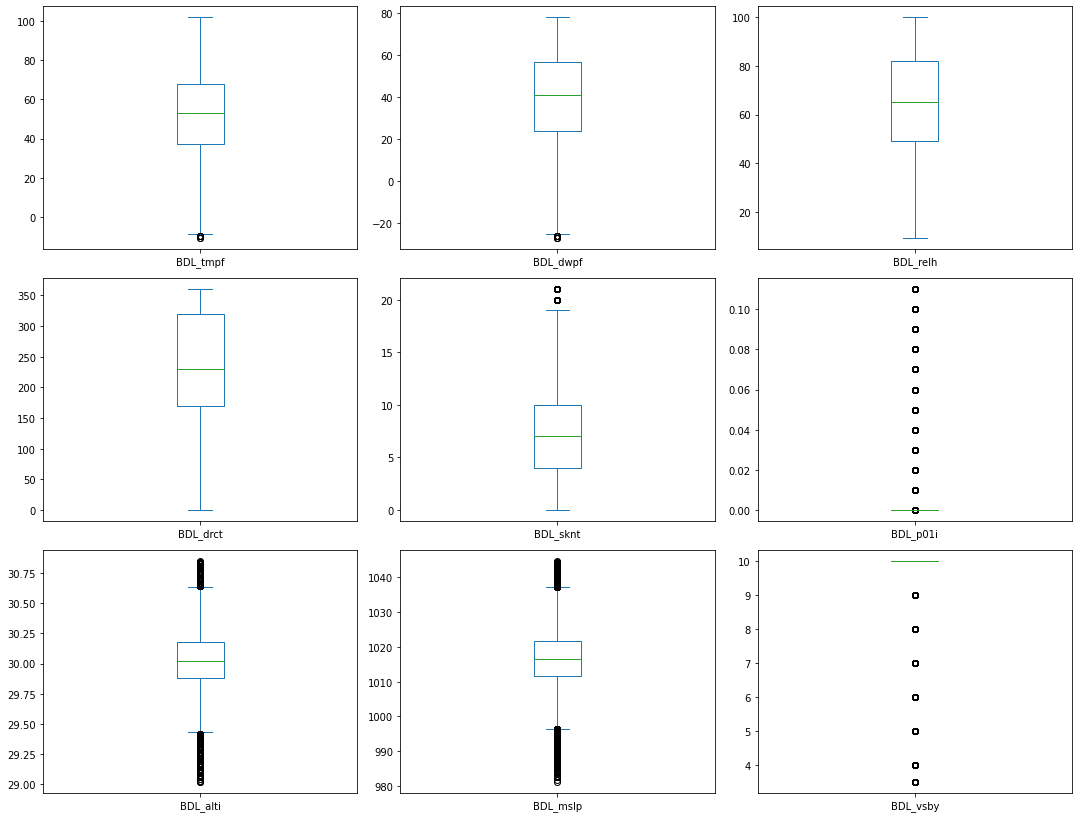

In [ ]:
# boxplots after removing outliers
tmp2.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.rcParams["figure.figsize"] = (15,15)
plt.tight_layout() 
plt.show()

#Correlation Analysis

In [ ]:
#Let's look at the correlation
tmp = df1.corr(method='pearson')
# rounded result to 2 decimal places for better readability
tmp = round(tmp, 2) 
tmp

,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby,year,hour,month
Demand,1.00,0.28,0.14,-0.29,0.02,0.13,-0.02,-0.07,-0.07,0.02,-0.19,0.45,-0.04
BDL_tmpf,0.28,1.00,0.89,-0.03,-0.07,0.05,-0.00,-0.25,-0.26,0.03,0.00,0.14,0.24
BDL_dwpf,0.14,0.89,1.00,0.42,-0.13,-0.12,0.09,-0.28,-0.30,-0.09,0.02,0.01,0.31
BDL_relh,-0.29,-0.03,0.42,1.00,-0.16,-0.36,0.23,-0.14,-0.14,-0.33,0.05,-0.27,0.19
BDL_drct,0.02,-0.07,-0.13,-0.16,1.00,0.37,-0.00,-0.11,-0.11,0.05,0.25,0.04,-0.04
BDL_sknt,0.13,0.05,-0.12,-0.36,0.37,1.00,0.05,-0.24,-0.24,0.06,0.20,0.18,-0.12
BDL_p01i,-0.02,-0.00,0.09,0.23,-0.00,0.05,1.00,-0.11,-0.12,-0.36,0.03,0.01,0.01
BDL_alti,-0.07,-0.25,-0.28,-0.14,-0.11,-0.24,-0.11,1.00,1.00,0.11,0.05,-0.03,0.06
BDL_mslp,-0.07,-0.26,-0.30,-0.14,-0.11,-0.24,-0.12,1.00,1.00,0.11,0.04,-0.03,0.05
BDL_vsby,0.02,0.03,-0.09,-0.33,0.05,0.06,-0.36,0.11,0.11,1.00,0.05,0.05,0.00


## Correlation matrix

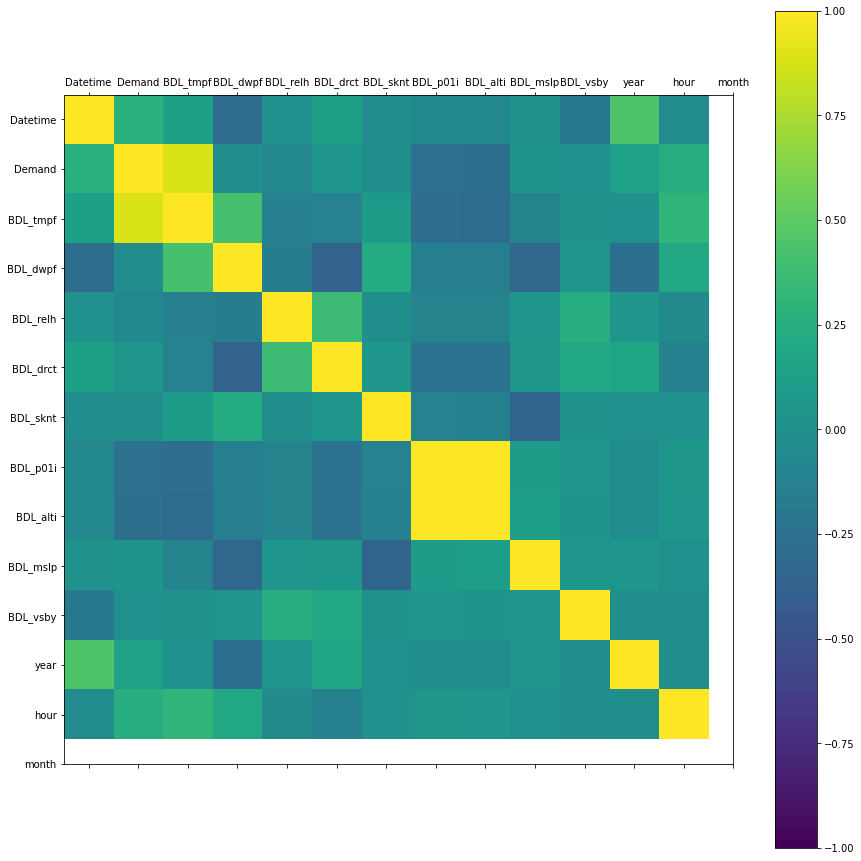

In [ ]:
# it can be a little involved to draw this with matplotlib
ax = plt.matshow(df1.corr(), vmin=-1, vmax=1)
plt.colorbar(ax)
ticks = np.arange(0, np.shape(df1.columns)[0], 1) # this is better than a hard-coded solution
plt.xticks(ticks, labels=df1.columns)
plt.yticks(ticks, labels=df1.columns)
plt.show()

We did not find any strong correlation between any two variables so we decided not to drop any columns using correlation matrix

# Feature Engineering


We converted Datetime column into month, year, weekday and hour columns for visualization in our EDA plots and extracting new features into our data model

In [ ]:
# from datetime import datetime

df1['year'] = df1['Datetime'].dt.year
df1['month'] = df1['Datetime'].dt.month
df1['hour'] = df1['Datetime'].dt.hour
df1['Weekno'] = df1['Datetime'].dt.weekday


# Train/Test Split


In [ ]:
# Subset the dataset based on the Date mentioned
# Partition into test and train data for building model
test = df1[df1['Datetime'] >= '2019-01-01']    #Test Data
train = df1[df1['Datetime'] < '2019-01-01']     #Train Data

# Set Datetime column as index for timeseries plots
train.set_index('Datetime', inplace= True)
test.set_index('Datetime', inplace= True)

In [ ]:
train.head()    #checking the work 

,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby,year,hour,month
Datetime,,,,,,,,,,,,,
2011-01-01 08:00:00,3052.0,33.98,28.04,78.62,20.0,3.0,0.0,30.12,1019.9,4.0,2011,8,1
2011-01-01 13:00:00,3269.0,50.00,35.06,56.30,170.0,5.0,0.0,30.04,1017.1,7.0,2011,13,1
2011-01-01 14:00:00,3250.0,50.00,33.98,53.92,160.0,3.0,0.0,30.02,1016.6,7.0,2011,14,1
2011-01-01 15:00:00,3319.0,48.92,35.06,58.61,180.0,6.0,0.0,30.02,1016.6,10.0,2011,15,1
2011-01-01 16:00:00,3628.0,46.94,35.06,63.13,190.0,5.0,0.0,30.01,1016.3,10.0,2011,16,1


In [ ]:
test.head()   #checking the work

,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby,year,hour,month
Datetime,,,,,,,,,,,,,
2019-01-01 00:00:00,2713.617,37.9,37.9,100.00,360.0,4.0,0.07,29.88,1009.7,5.0,2019,0,1
2019-01-01 05:00:00,2422.784,39.9,39.9,100.00,160.0,11.0,0.00,29.56,1000.4,5.0,2019,5,1
2019-01-01 06:00:00,2487.799,44.1,44.1,100.00,160.0,11.0,0.00,29.54,999.8,10.0,2019,6,1
2019-01-01 07:00:00,2530.716,46.9,46.0,96.66,170.0,11.0,0.00,29.54,1000.1,10.0,2019,7,1
2019-01-01 08:00:00,2620.610,48.9,48.0,96.69,170.0,10.0,0.00,29.56,1000.9,10.0,2019,8,1


In [ ]:

X_train = train.drop('Demand', axis = 1)   #dropping the target column from X_train
X_test = test.drop('Demand', axis = 1)     #dropping the target column from X_test
y_train = train['Demand']
y_test = test['Demand']

In [ ]:
# convert these all to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
#Scaling our data
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Baseline Model


##Random Forest ( Baseline Model)

In [ ]:
#Creating our baseline model as Random Forest
RFR = RandomForestRegressor(random_state=123)
RFR = RFR.fit(X_train, y_train)

In [ ]:
# store the predictions
train_preds_RFR = RFR.predict(X_train) 
test_preds_RFR = RFR.predict(X_test)

In [ ]:
# 1) R2 value - for Random Forest Regression
## compare test and train results with other models

print("This is train R2 (RFR):", r2_score(y_train, train_preds_RFR)) # train
print("This is test R2 (RFR):", r2_score(y_test, test_preds_RFR)) # test

This is train R2 (RFR): 0.9891650125120459
This is test R2 (RFR): 0.837482720638513


In [ ]:
# 2) MAE - for RF Regression
## compare test and train results with other models

trainMAE_RFR = mean_absolute_error(y_train, train_preds_RFR)
print("This is trainMAE (RFR):", trainMAE_RFR) # train
testMAE_RFR = mean_absolute_error(y_test, test_preds_RFR)
print("This is testMAE (RFR):", testMAE_RFR) # test

This is trainMAE (RFR): 56.94814208783866
This is testMAE (RFR): 213.9235159033946


In [ ]:
# 3) RMSE - for RF Regression
## compare test and train results with other models
trainMSE_RFR = mean_squared_error(y_train, train_preds_RFR)
print("This is trainRMSE (RFR):", sqrt(trainMSE_RFR))
testMSE_RFR = mean_squared_error(y_test, test_preds_RFR)
print("This is testRMSE (RFR):", sqrt(testMSE_RFR))

This is trainRMSE (RFR): 80.00876456807653
This is testRMSE (RFR): 291.27661739939083


# Best Model


## Gradient Boosting ( Best Model)

Tried various combinations for hyperparameter tuning taking MAE and RMSE into consideration. The GBR model with below parameters performed much better than the below combinations with less overfitting

**{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150}**

Other Hyper Parameter Combinations:

1.  *{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50}*
* This is train R2 (GBR): 0.9308612574753915
* This is test R2 (GBR): 0.8537158606910401


2.  *{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 50}*
*  This is train R2 (GBR): 0.9362506509481403
* This is test R2 (GBR): 0.8511314183388429


3.   *{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 75}*
*  This is train R2 (GBR): 0.9566992068193849
* This is test R2 (GBR): 0.8461428805786009


4.  *{'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 50}* 
*   This is train R2 (GBR): 0.9546924281662174
*   This is test R2 (GBR): 0.8492043790466302

5.  *{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}* - default
*   This is train R2 (GBR): 0.8922341985546368
*   This is test R2 (GBR): 0.8310799701475334

6.  *{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}*
*   This is train R2 (GBR): 0.9116881511583642
*   This is test R2 (GBR): 0.8557322112482487

7.  *{'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 150}*
*   This is train R2 (GBR): 0.9039717427506923
*   This is test R2 (GBR): 0.8516250996860216





In [ ]:
# After exploring various combinations in HyperParameter tuning we went ahead with our best result
# default - learning_rate = 0.1, max_depth = 3, n_estimators = 100
# learning_rate = 0.15, max_depth = 3, n_estimators = 150 2nd best
# learning_rate = 0.2, max_depth = 3, n_estimators = 150 best
GBR = GradientBoostingRegressor(random_state = 123, learning_rate = 0.2, max_depth = 3, n_estimators = 150)

# Fit the model
GBR = GBR.fit(X_train, y_train)

In [ ]:
# store the Test and Train predictions
train_preds = GBR.predict(X_train) 
test_preds = GBR.predict(X_test) 


#  Model Evaluation
Now that model has fit, it's time to dig into the results.

##  Quantitative


In [ ]:
# 1) R2 value - for GBR Regression
print("This is train R2 (GBR):", r2_score(y_train, train_preds)) # train
print("This is test R2 (GBR):", r2_score(y_test, test_preds)) # test

This is train R2 (GBR): 0.9061681760765009
This is test R2 (GBR): 0.8532120971483217


In [ ]:
# 2) MAE - for GBR Regression
trainMAE = mean_absolute_error(y_train, train_preds)
print("This is train MAE (GBR):", trainMAE) # train
testMAE = mean_absolute_error(y_test, test_preds)
print("This is test MAE (GBR):", testMAE) # test

This is train MAE (GBR): 177.95300135889948
This is test MAE (GBR): 204.2874323385479


In [ ]:
# 3) RMSE - for GBR Regression
trainMSE = mean_squared_error(y_train, train_preds)
print("This is train RMSE (GBR):", sqrt(trainMSE)) # train
testMSE = mean_squared_error(y_test, test_preds)
print("This is test RMSE (GBR):", sqrt(testMSE)) # test

This is train RMSE (GBR): 235.44985998626888
This is test RMSE (GBR): 276.8222432738714


##  Qualitative


## Scatterplots of actual vs. predicted

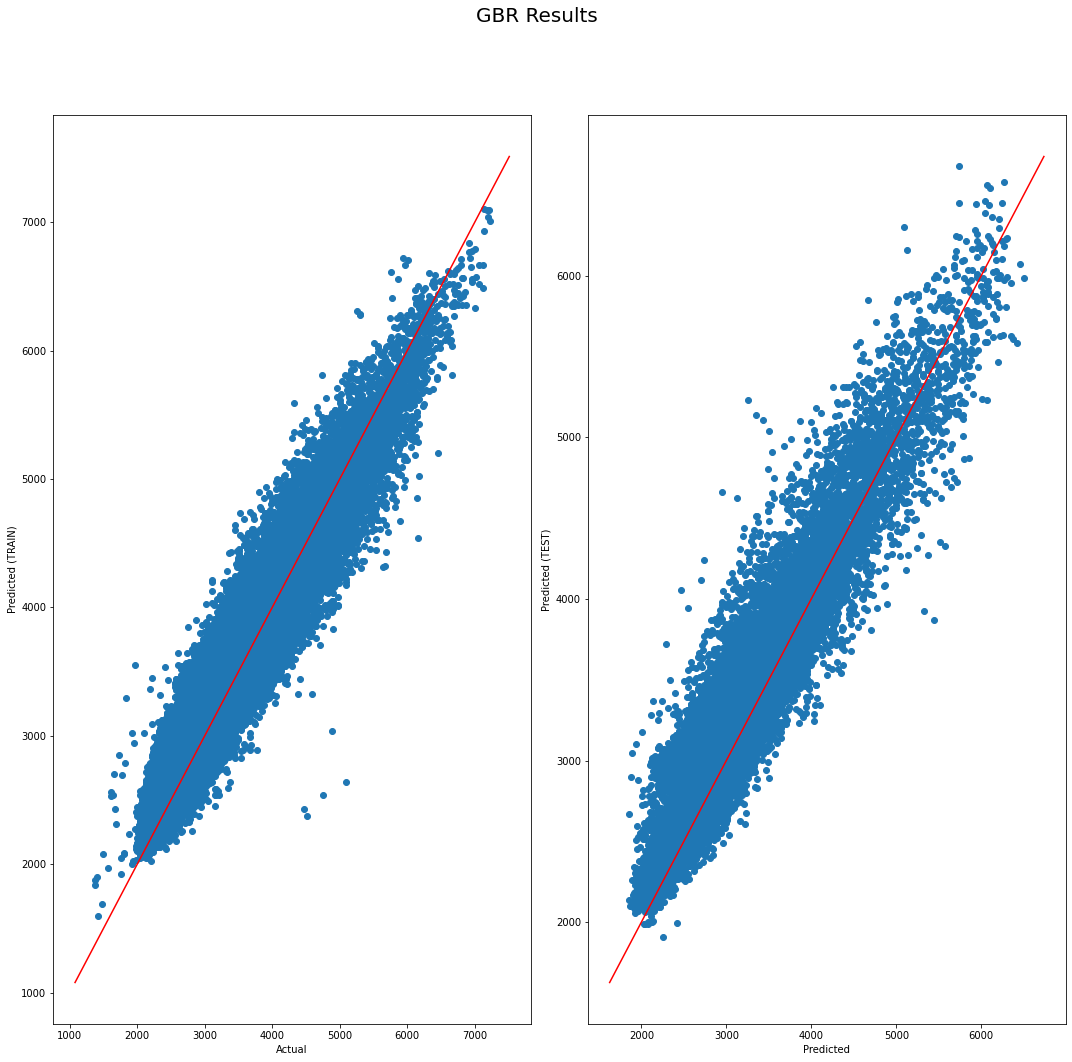

In [ ]:
# specify the dimensions and figure alignment
fig, axes = plt.subplots(1,2) # 1 row, 2 columns


# Plot Title 
fig.suptitle("GBR Results", fontsize=20)

# Subplot 1 - Train
axes[0].scatter(x=y_train, y=train_preds) 
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted (TRAIN)",  fontsize=10)
# add 45 degree line to left panel
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')

# Subplot 2 - Test
axes[1].scatter(x=y_test, y=test_preds)
axes[1].set_xlabel("Predicted", fontsize=10)
axes[1].set_ylabel("Predicted (TEST)",  fontsize=10)
# add 45 degree line to right panel
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# scooch it down
fig.subplots_adjust(top=0.88)

# show the plot
plt.show()

The plot above shows us the relationship between the actual and the predicted values.
How the scatterplot gives us the most detail here - We can see the blue colour in both the graph is equally distributed and follows a linear trend, as it does not over estimate or underestimate.
Left graph shows us the actual and predicted graph for train result while the right graph shows us the actual and predicted graph for test result.

On the basis of our accuracy of 85.32%, we can say that we are getting almost similiar results where the graph on the test result is not much scattered on comparing it to train result. It's little bit scattered on the top right side, depending on our accuracy.

##Time series plots of actual vs. predicted

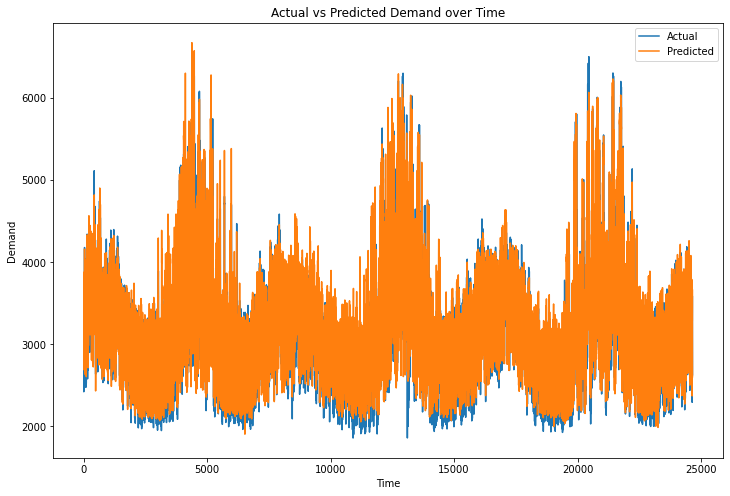

In [ ]:
import plotly.graph_objs as go
actual = y_test
pred = test_preds

plt.figure(figsize=(12,8))
plt.plot(actual, label = 'Actual')
plt.plot(pred, label = 'Predicted')
plt.title('Actual vs Predicted Demand over Time')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()



The graph above shows us the relationship between the actual and the predicted values on the basis of time
where the blue lines are the actual data lines and orange ones are the predicted ones.
Also, here the time is in numerical form since we have the data on an hourly basis, therefore its combining each row hourly data and then giving us the results.

Furthermore, we can say the predicted values we are getting are nearly identical to the actual values. Since our accuracy is 83%, therefore the predicted data is not capturing some of the lower values from the actual data. However, when the data is viewed at its peak, predicted data is almost exactly capturing the same data.


# Conclusion
* My best test MAE was: 204.287
* My best test RMSE was: 276.82



Baseline Model was Random forest Model which had the Test R2 of 83.74 but when we compared the values of MAE and RMSE of test and train, the difference was very large which resulted in significant overfitting our baseline model.

To resolve this, best model to be Gradient Boosting by adjusting our hyper parameters which gave Test R2 of 85.32 and the values of MAE and RMSE in test and train were very close making the model less overfitting and giving better predictions.